In [28]:
import numpy as np
import matplotlib.pyplot as plt

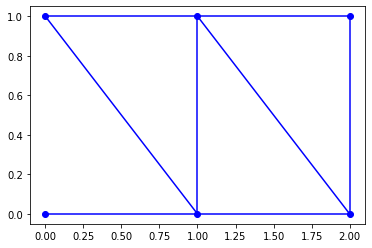

In [29]:
# --- Mesh definition ---
# Defining a truss manually

nodes = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1],
    [2, 0],
    [2, 1]
])

elems = np.array([
    [0, 2],
    [1, 2],
    [1, 3],
    [2, 3],
    [2, 4],
    [3, 4],
    [3, 5],
    [4, 5]
])

def plot(nodes, elems, c):
    '''Plot nodes and elements'''
    plt.plot(nodes[:, 0], nodes[:, 1], 'o'+c)
    for elem in elems:
        pair = np.array([nodes[elem[0]], nodes[elem[1]]])
        plt.plot(pair[:, 0], pair[:, 1], '-'+c)

plot(nodes, elems, 'b')
plt.show()

In [30]:
# --- Element specific stiffness matrix formulation ---
# Method of weighted residuals generalises this

dof = 2 # Node dof

def rot(cos_t, sin_t) -> np.ndarray:
    '''Returns rotation matrix for bar element'''
    return np.array([
        [cos_t, sin_t, 0, 0],
        [0, 0, sin_t, cos_t]
        ])

# Element stiffness matrix in local coordinate system
K_loc = np.array([
    [1, -1],
    [-1, 1]
])

print(np.round(K_loc@rot(np.cos(45), np.sin(45)), 2))

[[ 0.53  0.85 -0.85 -0.53]
 [-0.53 -0.85  0.85  0.53]]


In [31]:
# --- System Assembly ---

A, E = 1, 1

gdof = dof*len(nodes)
K_glob = np.zeros((gdof, gdof)) # Global stiffness matrix

for elem in elems:

    v = nodes[elem][0] - nodes[elem][1] # Vector between nodes of element
    L = np.linalg.norm(v) # Norm 
    c = v[0]/L # cos(theta)
    s = v[1]/L # sin(theta)

    rot_elem = rot(c, s)
    k_elem_glob = (1/L) * rot_elem.T@K_loc@rot_elem # Element stiffness matrix in global coordinate system

    # Distribute element stiffness matrix onto corresponding notes in global stiffness matrix
    for a, i in enumerate(elem):
        for b, j in enumerate(elem):
            K_glob[dof*i:dof*(i+1), dof*j:dof*(j+1)] += k_elem_glob[dof*a:dof*(a+1), dof*b:dof*(b+1)]

    K_glob *= A*E # Assuming bars have same cross sectional area and Young's modulus

print(np.round((K_glob), 2))

[[ 1.    0.    0.    0.    0.   -1.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    1.35 -0.35  0.35 -0.35  0.   -1.    0.    0.    0.    0.  ]
 [ 0.    0.   -0.35  0.35 -0.35  0.35  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.35 -0.35  1.35 -0.35  0.    0.    0.   -1.    0.    0.  ]
 [-1.    0.   -0.35  0.35 -0.35  2.35 -1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.   -1.    2.35 -0.35  0.35 -0.35  0.   -1.  ]
 [ 0.    0.   -1.    0.    0.    0.   -0.35  1.35 -0.35  0.35  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.35 -0.35  0.35 -0.35  0.    0.  ]
 [ 0.    0.    0.    0.   -1.    0.   -0.35  0.35 -0.35  2.35 -1.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.   -1.    1.    0.  ]
 [ 0.    0.    0.    0.    0.    0.   -1.    0.    0.    0.    0.    1.  ]]


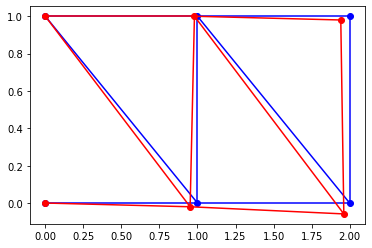

In [32]:
# --- Boundary Conditions + Solving ---

F = np.array([0, 0, 0, 0, 0, -0.01, 0, 0, 0, -0.01, 0, 0])
u = np.zeros_like(F)

# Omit rows + columns of constrained nodes and solve
u[dof*2:] = np.linalg.solve(K_glob[dof*2:, dof*2:], F[dof*2:])

u = u.reshape(-1, 2) # Reshape column vector into shape of nodes array

plot(nodes, elems, 'b')
plot(nodes + u, elems, 'r')
plt.show()